# Basic analyze <img align="right" src="image/gistda.png" width="200" height="200">

This tutorial illustrates the process of manually calculating band indices by utilizing various band values present in satellite images.

<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/DreamPTK/rice-detection/blob/main/Tutorial/Basic_analyze.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

## Import package

In [1]:
import datacube
import matplotlib.pyplot as plt
from dream_river.plotimg import rgb
from datacube.utils.cog import write_cog

## Connect to datacube

In [2]:
# connect to datacube
dc = datacube.Datacube(app='basic_analyze')

## Choose a study area and set image parameter

<img src="image/latlong_buffer.png" width="250" height="250">

In [3]:
# Set the central latitude and longitude
central_lat = 11.800
central_lon = 99.790

# Set the buffer to load around the central coordinates
buffer = 0.05

# date range for analysis
time_range = ("2015-01-01","2015-02-28")

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

In [4]:
# set query for load data
query = {
    'y': study_area_lat,
    'x': study_area_lon,
    'time': time_range,
    'measurements': ['red', 'green', 'blue','nir'],
    'resolution': (-30, 30),
    'output_crs': 'epsg:32647',
    'group_by':'solar_day'
}

## Load data from query

In [5]:
# Loading data using dc.load()
ds = dc.load(product="ls8_collections_sr_scene",**query)
ds

<xarray.Dataset>
Dimensions:      (time: 4, y: 371, x: 365)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-04T03:38:36 ... 2015-02-21T03:...
  * y            (y) float64 1.31e+06 1.31e+06 1.31e+06 ... 1.299e+06 1.299e+06
  * x            (x) float64 5.806e+05 5.806e+05 ... 5.915e+05 5.915e+05
    spatial_ref  int32 32647
Data variables:
    red          (time, y, x) int16 1377 1312 967 827 762 ... 164 154 166 156
    green        (time, y, x) int16 1105 1073 871 764 706 ... 411 402 402 388
    blue         (time, y, x) int16 739 674 462 391 334 ... 415 414 408 410 399
    nir          (time, y, x) int16 2537 2986 3506 3146 2965 ... 100 90 102 101
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

## Plot data

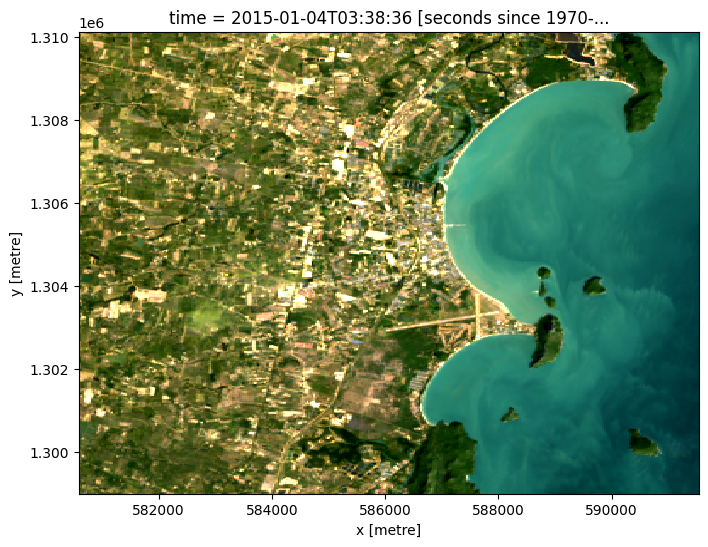

In [6]:
rgb(ds, bands=['red','green', 'blue'], index =0) 

## Calculate Vegetation health

While it's possible to identify vegetation in the RGB image, it can be helpful to have a quantitative index to describe the health of vegetation directly. 

In this case, the [Normalised Difference Vegetation Index](https://www.gistda.or.th/ewtadmin/ewt/gistda_web/news_view.php?n_id=2894&lang=TH) (NDVI) can help identify areas of healthy vegetation.
For remote sensing data such as satellite imagery, it is defined as

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band.
NDVI can take on values from -1 to 1; high values indicate healthy vegetation and negative values indicate non-vegetation (such as water). 

The following code calculates the top and bottom of the fraction separately, then computes the NDVI value directly from these components.
The calculated NDVI values are stored as their own data array.

In [7]:
# Calculate the components that make up the NDVI calculation
band_diff = ds.nir - ds.red
band_sum = ds.nir + ds.red

# Calculate NDVI and store it as a measurement in the original dataset
ndvi = band_diff / band_sum

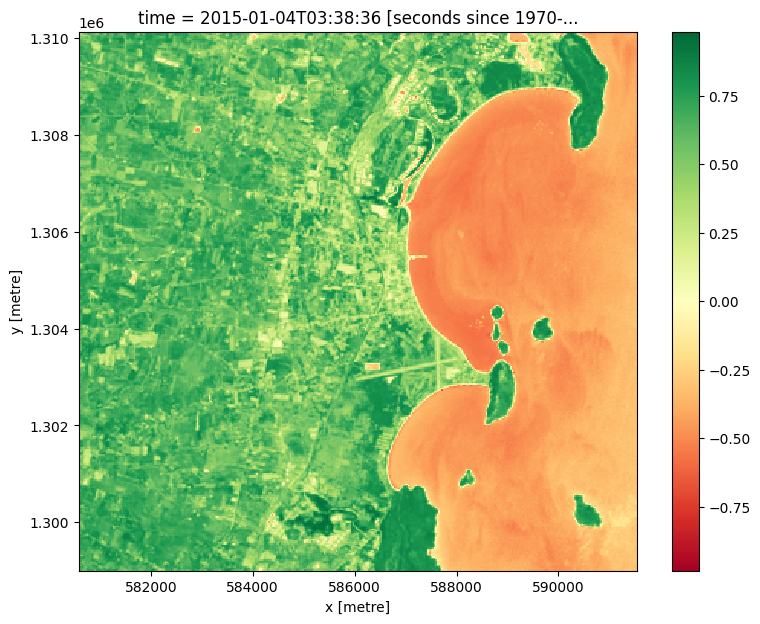

In [8]:
# Set the NDVI time step to view
ndvi_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(9, 7))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
plt.show()

## Export data

In [9]:
# Set a file 
filename = "ndvi.tiff"

write_cog(geo_im=ndvi.isel(time=ndvi_time_step), fname=filename, overwrite=True);